# **Variational Autoencoder (VAE) – Training with Reparameterization Trick**

We want to train a **latent variable model** \( p_\theta(x) \) of the form:

$$
p_\theta(x) = \int p_\theta(x|z) p(z) \, dz
$$

where:

- \( z \) is the latent variable
- \( p(z) = \mathcal{N}(0, I) \) is the prior

---

### **1️⃣ Encoder (Recognition Model)**

The encoder approximates the posterior \( q_\phi(z|x) \) as a Gaussian:

$$
q_\phi(z|x) = \mathcal{N}\big( z; \mu_\phi(x), \sigma_\phi^2(x) \big)
$$

- Encoder outputs:
  $$ \mu_\phi(x), \sigma_\phi(x) $$

---

### **2️⃣ Reparameterization Trick**

Directly sampling \( z \sim q_\phi(z|x) \) is **not differentiable**, so we use:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon
$$

where:

- \( \epsilon \sim \mathcal{N}(0, I) \)  
- This allows **gradients to flow** through \( \mu_\phi \) and \( \sigma_\phi \)

---

### **3️⃣ Decoder (Generative Model)**

The decoder maps latent \( z \) back to data space:

$$
p_\theta(x|z) = \mathcal{N}\big(x; \hat{x}_\theta(z), I\big)
$$

- Output of decoder: \( \hat{x}_\theta(z) \)

---

### **4️⃣ ELBO Objective**

The **Evidence Lower Bound (ELBO)** to maximize is:

$$
\mathcal{L}(\theta, \phi; x) =
\mathbb{E}_{q_\phi(z|x)}\big[ \log p_\theta(x|z) \big]
- \text{KL}\big( q_\phi(z|x) \Vert p(z) \big)
$$

- **Reconstruction Loss:**
  $$
  \mathbb{E}_{q_\phi(z|x)}[ \log p_\theta(x|z) ]
  $$

- **KL Divergence:**
  $$
  \text{KL}\big( \mathcal{N}(\mu_\phi(x), \sigma_\phi^2(x))
  \,||\, \mathcal{N}(0, I) \big)
  $$

---

### **5️⃣ Training Steps**

**Forward Pass:**
1. Input \( x \) → Encoder → \( \mu_\phi(x), \sigma_\phi(x) \)
2. Sample \( \epsilon \sim \mathcal{N}(0, I) \)
3. Compute \( z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon \)
4. Decoder: \( \hat{x}_\theta = p_\theta(x|z) \)
5. Compute ELBO loss

**Backward Pass:**
- Compute gradients of ELBO w.r.t:
  - Encoder parameters \( \phi \)
  - Decoder parameters \( \theta \)
- Update using gradient descent

---

### **6️⃣ Summary of One Training Step**

1. Encode \( x \) to \( \mu_\phi(x), \sigma_\phi(x) \)
2. Sample \( z \) via reparameterization
3. Decode \( z \) to reconstruct \( \hat{x}_\theta \)
4. Compute:
   $$
   \mathcal{L} = \text{Recon Loss} + \text{KL Loss}# **Variational Autoencoder (VAE) – Training with Reparameterization Trick**

We want to train a **latent variable model** $$ p_\theta(x) $$ of the form:

$$
p_\theta(x) = \int p_\theta(x|z) \, p(z) \, dz
$$

where:

- $$ z $$ is the latent variable
- $$ p(z) = \mathcal{N}(0, I) $$ is the prior



# **Variational Autoencoder (VAE) – Training with Reparameterization Trick**

We want to train a latent variable model:

$$
p_\theta(x) = \int p_\theta(x|z)p(z) \, dz
$$

where:

- $$z$$ is the **latent variable**  
- $$p(z)=\mathcal{N}(0,I)$$ is the **prior**


## 1️⃣ Generate Data for Training

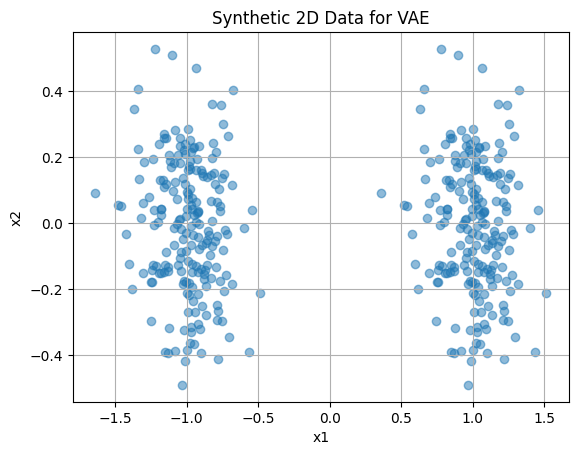

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

# 1️⃣ Generate simple 2D dataset (two blobs)
key = random.PRNGKey(0)
num_samples = 200

cluster1 = random.normal(key, (num_samples,2)) * 0.2 + jnp.array([1,0])
cluster2 = random.normal(key, (num_samples,2)) * 0.2 + jnp.array([-1,0])
X_data = jnp.concatenate([cluster1, cluster2], axis=0)

plt.scatter(X_data[:,0], X_data[:,1], alpha=0.5)
plt.title("Synthetic 2D Data for VAE")
plt.xlabel("x1"); plt.ylabel("x2"); plt.grid(True); plt.show()


## **2️⃣ Encoder – Compute \( \mu_\phi(x) \) and \( \sigma_\phi(x) \)**

The **encoder (recognition model)** maps input \( x \) to a Gaussian distribution:

$$
q_\phi(z|x) = \mathcal{N}\big( z; \mu_\phi(x), \sigma_\phi^2(x) \big)
$$

Outputs:

- \( \mu_\phi(x) \) → Mean of latent distribution  
- \( \sigma_\phi(x) \) → Standard deviation of latent distribution  

Step 1: Encoder Outputs
Mu first 5:
 [[ 0.7432748  -0.23533738]
 [ 0.45349586 -0.28027374]
 [ 0.47872555 -0.3883326 ]
 [ 0.47024527 -0.2307318 ]
 [ 0.5284284  -0.41587406]]
Logvar first 5:
 [[ 0.01093695 -0.14338979]
 [ 0.09604515 -0.18737325]
 [ 0.16184717 -0.265369  ]
 [ 0.06043131 -0.15052533]
 [ 0.1702968  -0.2835838 ]]


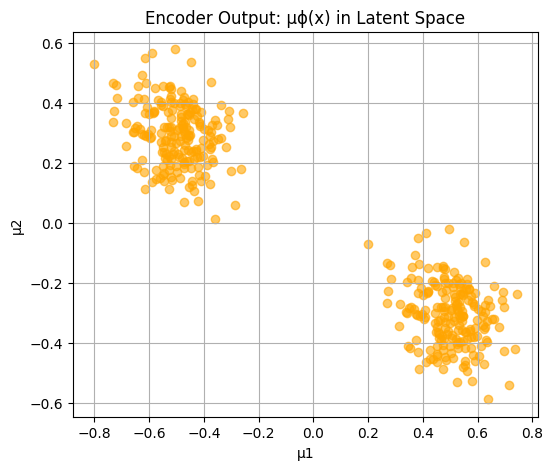

In [2]:
def encoder(x):
    """Outputs mu and logvar for q_phi(z|x)"""
    mu = jnp.dot(x, jnp.array([[0.5, -0.3],[0.2,0.4]]))  # 2→2
    logvar = jnp.dot(x, jnp.array([[0.1,-0.2],[-0.3,0.3]]))  # 2→2
    return mu, logvar

mu, logvar = encoder(X_data)

print("Step 1: Encoder Outputs")
print("Mu first 5:\n", mu[:5])
print("Logvar first 5:\n", logvar[:5])

plt.figure(figsize=(6,5))
plt.scatter(mu[:,0], mu[:,1], alpha=0.6, color='orange')
plt.title("Encoder Output: μϕ(x) in Latent Space")
plt.xlabel("μ1"); plt.ylabel("μ2"); plt.grid(True); plt.show()


## **3️⃣ Reparameterization Trick**

We cannot backpropagate through the stochastic sampling directly.  
Instead, we reparameterize:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon
$$

Where:

- \( \epsilon \sim \mathcal{N}(0, I) \)  
- \( \odot \) is elementwise multiplication  

**Purpose:**  
Allows gradients to flow through \( \mu_\phi(x) \) and \( \sigma_\phi(x) \) during training.


Step 2: Sampled z (first 5):
 [[-1.7125741  -2.130179  ]
 [ 0.6691517  -0.6022053 ]
 [-0.34747374 -1.4204391 ]
 [-0.71319795  0.04488941]
 [-0.8985862   1.4327197 ]]


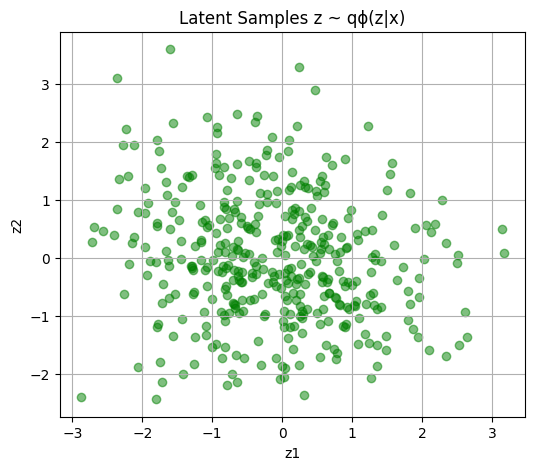

In [3]:
def sample_latent(mu, logvar, key):
    eps = random.normal(key, mu.shape)
    return mu + jnp.exp(0.5 * logvar) * eps

key, subkey = random.split(key)
z = sample_latent(mu, logvar, subkey)

print("Step 2: Sampled z (first 5):\n", z[:5])

plt.figure(figsize=(6,5))
plt.scatter(z[:,0], z[:,1], alpha=0.5, color='green')
plt.title("Latent Samples z ~ qϕ(z|x)")
plt.xlabel("z1"); plt.ylabel("z2"); plt.grid(True); plt.show()


## **4️⃣ Decoder – Map \( z \) back to \( \hat{x}_\theta(z) \)**

The **decoder (generative model)** reconstructs \( x \) from the latent variable \( z \):

$$
p_\theta(x|z) = \mathcal{N}\big( x; \hat{x}_\theta(z), I \big)
$$

-  $ \( \hat{x}_\theta(z) \$)  is the reconstructed sample  
- This forces the model to learn a meaningful latent representation


Step 3: Decoder Reconstructions (first 5):
 [[-1.8378556   0.43025127]
 [ 0.2877446  -0.4550169 ]
 [-0.6693634  -0.11035096]
 [-0.48577172  0.36557686]
 [-0.19919439  0.73583704]]


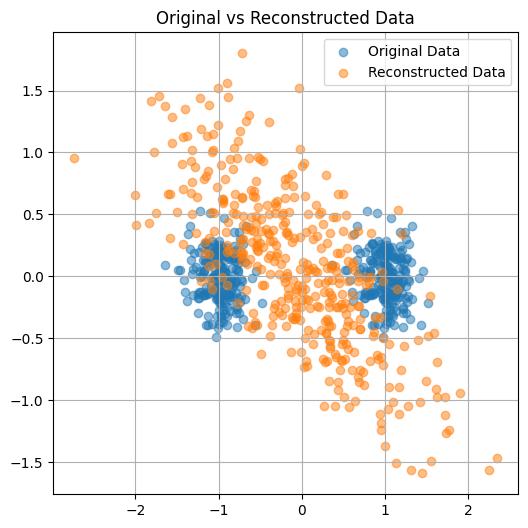

In [4]:
def decoder(z):
    """Simple linear decoder"""
    return jnp.dot(z, jnp.array([[0.7,-0.5],[0.3,0.2]]))

X_recon = decoder(z)

print("Step 3: Decoder Reconstructions (first 5):\n", X_recon[:5])

plt.figure(figsize=(6,6))
plt.scatter(X_data[:,0], X_data[:,1], alpha=0.5, label='Original Data')
plt.scatter(X_recon[:,0], X_recon[:,1], alpha=0.5, label='Reconstructed Data')
plt.legend(); plt.title("Original vs Reconstructed Data"); plt.grid(True); plt.show()


## **5️⃣ ELBO Loss (Reconstruction + KL Divergence)**

The **Evidence Lower Bound (ELBO)** for one sample is:

$$
\mathcal{L}(x) =
\underbrace{ \| x - \hat{x}_\theta(z) \|^2 }_{\text{Reconstruction Loss}}
+
\underbrace{ -\frac{1}{2} \sum \big( 1 + \log \sigma^2_\phi(x) - \mu_\phi^2(x) - \sigma_\phi^2(x) \big) }_{\text{KL Divergence}}
$$

- **Reconstruction Term:** Forces the decoder to output \( \hat{x}_\theta \approx x \)  
- **KL Term:** Pushes \( q_\phi(z|x) \) to be close to the prior \( p(z) = \mathcal{N}(0,I) \)  

In [5]:
def elbo_loss(x, x_recon, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = jnp.mean(jnp.sum((x - x_recon)**2, axis=1))
    # KL divergence term
    kl_loss = -0.5 * jnp.mean(jnp.sum(1 + logvar - mu**2 - jnp.exp(logvar), axis=1))
    return recon_loss + kl_loss, (recon_loss, kl_loss)

loss, (recon, kl) = elbo_loss(X_data, X_recon, mu, logvar)
print(f"Step 4: ELBO Loss = {loss:.4f}, Recon = {recon:.4f}, KL = {kl:.4f}")


Step 4: ELBO Loss = 1.9318, Recon = 1.7367, KL = 0.1951


## **6️⃣ Visualization of Training Concept**

---

**1. Encoder:**

$$
x \to (\mu_\phi(x), \sigma_\phi(x))
$$

**2. Latent Sampling:**

$$
z = \mu_\phi(x) + \sigma_\phi(x) \epsilon, \quad
\epsilon \sim \mathcal{N}(0,I)
$$

**3. Decoder:**

$$
z \to \hat{x}_\theta(z)
$$

**4. Loss:**

$$
\text{ELBO} = \text{Recon Loss} + \text{KL Loss}
$$

---

**Training intuition:**

- The **encoder compresses** the input into a latent Gaussian  
- The **decoder reconstructs** the input from the latent code  
- The **KL divergence** ensures the latent space is structured and smooth  
- The **reparameterization trick** makes the whole process **differentiable**

---


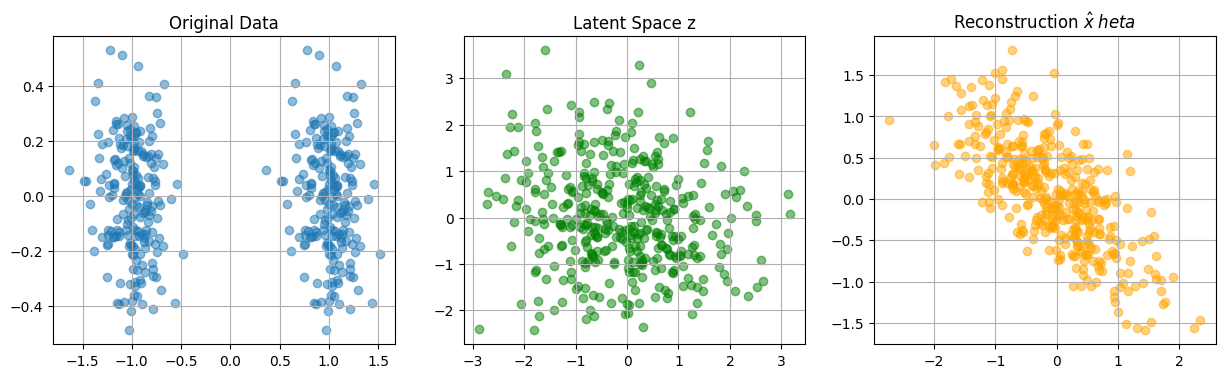

In [6]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].scatter(X_data[:,0], X_data[:,1], alpha=0.5)
ax[0].set_title("Original Data"); ax[0].grid(True)

ax[1].scatter(z[:,0], z[:,1], alpha=0.5, color='green')
ax[1].set_title("Latent Space z"); ax[1].grid(True)

ax[2].scatter(X_recon[:,0], X_recon[:,1], alpha=0.5, color='orange')
ax[2].set_title("Reconstruction $\hat{x}_\theta$"); ax[2].grid(True)

plt.show()
